<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_09/03_b_transfer_learning_tfhub_efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
(train_ds, val_ds), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

def format_image(image, label):
    image = tf.image.resize(image, IMG_SIZE) / 255.0
    return image, label

train_ds = train_ds.map(format_image).batch(BATCH_SIZE).prefetch(1)
val_ds = val_ds.map(format_image).batch(BATCH_SIZE).prefetch(1)
NUM_CLASSES = ds_info.features['label'].num_classes


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.AGPD96_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 5  # tf_flowers dataset has 5 classes

# Base model with pre-trained ImageNet weights
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=INPUT_SHAPE)
base_model.trainable = False  # for feature extraction


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = preprocess_input(inputs)  # preprocess like ImageNet
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(NUM_CLASSES)(x)

model = tf.keras.Model(inputs, outputs)

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 63s 438ms/step - accuracy: 0.2458 - loss: 1.6078 - val_accuracy: 0.1635 - val_loss: 1.6550
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.2426 - loss: 1.6094 - val_accuracy: 0.1635 - val_loss: 1.6551
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.2341 - loss: 1.6092 - val_accuracy: 0.1635 - val_loss: 1.6591
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.2500 - loss: 1.6089 - val_accuracy: 0.2316 - val_loss: 1.6567
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.2408 - loss: 1.6056 - val_accuracy: 0.1635 - val_loss: 1.6620


In [15]:
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 142s 712ms/step - accuracy: 0.2143 - loss: 7.2624 - val_accuracy: 0.2153 - val_loss: 11.0991
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 0.2908 - loss: 5.9868 - val_accuracy: 0.1567 - val_loss: 10.5990
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - accuracy: 0.3151 - loss: 5.4187 - val_accuracy: 0.1649 - val_loss: 10.3109


In [16]:
import numpy as np

# Get predicted logits
y_pred_logits = model.predict(val_ds)
y_pred = np.argmax(y_pred_logits, axis=1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 300ms/step


In [17]:
# Extract true labels
y_true = np.concatenate([y for _, y in val_ds], axis=0)

Classification Report:

              precision    recall  f1-score   support

           0       0.17      0.54      0.26       159
           1       0.24      0.13      0.17       120
           2       0.11      0.02      0.03       186
           3       0.12      0.07      0.09       138
           4       0.09      0.05      0.06       131

    accuracy                           0.16       734
   macro avg       0.15      0.16      0.12       734
weighted avg       0.14      0.16      0.12       734



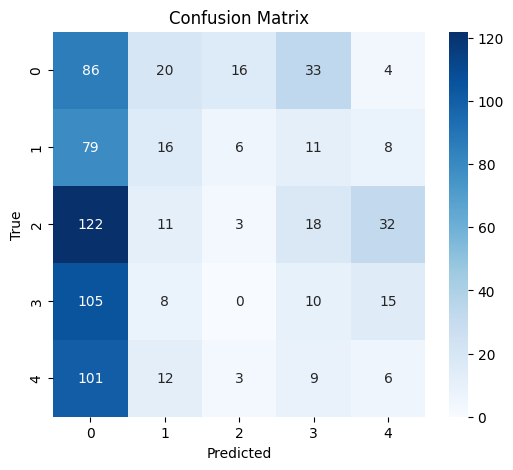

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Classification Report:\n")
print(classification_report(y_true, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()